In [113]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from py_vollib.black_scholes import black_scholes


In [276]:
nifty = pd.read_csv("NIFTY 50_Historical_PR_01041994to30042025.csv")
vix = pd.read_csv("India VIX Historical Data.csv")

nifty.set_index(pd.to_datetime(nifty['Date']), drop = True, inplace = True)
nifty = nifty['Close']
nifty.sort_index(inplace=True)


vix.set_index(pd.to_datetime(vix['Date']), drop = True, inplace = True)
vix  = vix['Price']
vix.sort_index(inplace=True)
vix = vix.to_frame()

data = pd.concat([nifty, vix], axis = 1).dropna()
data.columns = ['nifty_price','vix_price']


data['day_name'] = data.index.day_name()
data['original_date'] = data.index
data = data.resample('W-THU').last()
data['time_to_expiry'] =(data['original_date'].shift(-1) - data['original_date'])
data['time_to_expiry'] = data['time_to_expiry'].apply(lambda x: x.days)
data.set_index('original_date', drop = True, inplace = True)

data['market_open_days'] = data['time_to_expiry'] - 2

std = 2.38
data['lower_range'] = round((data['nifty_price'] * (1 - ((std/100) * (data['market_open_days']**0.5))))/50)*50
data['upper_range'] = round((data['nifty_price'] * (1 + ((std/100) * (data['market_open_days']**0.5))))/50)*50


def compute_call_price(row):
    return black_scholes(
        'c',
        float(row['nifty_price']),
        float(row['upper_range']),
        float(row['time_to_expiry']) / 365,
        0.05,  # risk-free rate
        float(row['vix_price']) / 100  # convert to decimal
    )

def compute_put_price(row):
    return black_scholes(
        'p',
        float(row['nifty_price']),
        float(row['lower_range']),
        float(row['time_to_expiry']) / 365,
        0.05,  # risk-free rate
        float(row['vix_price']) / 100  # convert to decimal
    )

data['call_premium'] = data.apply(compute_call_price, axis=1)
data['put_premium'] = data.apply(compute_put_price, axis=1)

data['put_profit_or_loss'] = (((data['lower_range'] - data['nifty_price'].shift(-1))*-1)/data['nifty_price'])*100
data['call_profit_or_loss'] = ((data['upper_range'] - data['nifty_price'].shift(-1))/data['nifty_price'])*100


data['50_ma'] = data['nifty_price'].rolling(10).mean()
data = data.dropna()

data = data[data['vix_price']<25]
data = data.loc['2015':]
data

,nifty_price,vix_price,day_name,time_to_expiry,market_open_days,lower_range,upper_range,call_premium,put_premium,put_profit_or_loss,call_profit_or_loss,50_ma
original_date,,,,,,,,,,,,
2015-01-01,8284.00,15.0250,Thursday,7.0,5.0,7850.0,8700.0,0.630152,0.221402,4.642685,5.618059,8323.615
2015-01-08,8234.60,16.4725,Thursday,7.0,5.0,7800.0,8650.0,1.192824,0.469493,8.429675,1.892624,8330.155
2015-01-15,8494.15,16.1600,Thursday,7.0,5.0,8050.0,8950.0,0.728725,0.442140,8.375176,2.220352,8345.740
2015-01-22,8761.40,18.5650,Thursday,7.0,5.0,8300.0,9250.0,1.609450,1.262727,7.445728,3.397288,8386.095
2015-01-29,8952.35,19.4325,Thursday,7.0,5.0,8500.0,9450.0,2.247572,2.202320,2.364742,8.246997,8441.140
...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-13,22397.20,13.2800,Thursday,7.0,5.0,21200.0,23600.0,0.330096,0.133174,8.887941,1.827684,23032.800
2025-03-20,23190.65,12.6025,Thursday,7.0,5.0,21950.0,24400.0,0.259772,0.071482,7.080224,3.484378,22999.215
2025-03-27,23591.95,13.3000,Thursday,7.0,5.0,22350.0,24850.0,0.376806,0.168410,3.815284,6.781550,23027.230


In [277]:
data[data['call_profit_or_loss']<0]

,nifty_price,vix_price,day_name,time_to_expiry,market_open_days,lower_range,upper_range,call_premium,put_premium,put_profit_or_loss,call_profit_or_loss,50_ma
original_date,,,,,,,,,,,,
2016-02-25,6970.60,22.745,Thursday,7.0,5.0,6600.0,7350.0,4.626215,3.328326,12.561329,-1.801853,7415.665
2019-09-19,10704.80,15.550,Thursday,7.0,5.0,10150.0,11250.0,0.965274,0.428029,13.276287,-3.000523,11011.605
2020-09-24,10805.55,23.510,Thursday,7.0,5.0,10250.0,11400.0,8.093239,7.056254,10.799543,-0.156864,11298.800
2021-01-28,13817.55,24.290,Thursday,7.0,5.0,13100.0,14550.0,13.748370,10.174205,12.995430,-2.501529,13821.175
2025-04-09,22399.15,21.430,Wednesday,8.0,6.0,21100.0,23700.0,11.968351,7.273739,12.284618,-0.677035,22946.670


In [278]:
data[(data['put_profit_or_loss']<0) & (data['nifty_price']>data['50_ma'])]['put_profit_or_loss'].value_counts(bins=10, sort=False)

(-0.8210999999999999, -0.8208]    0
(-0.8208, -0.8206]                0
(-0.8206, -0.8205]                0
(-0.8205, -0.8203]                0
(-0.8203, -0.8202]                1
(-0.8202, -0.82]                  0
(-0.82, -0.8198]                  0
(-0.8198, -0.8197]                0
(-0.8197, -0.8195]                0
(-0.8195, -0.8193]                0
Name: count, dtype: int64

In [279]:
data[(data['call_profit_or_loss']<0)&(data['nifty_price']<data['50_ma'])]['call_profit_or_loss'].value_counts(bins=10, sort=False)

(-3.004, -2.716]    1
(-2.716, -2.432]    1
(-2.432, -2.147]    0
(-2.147, -1.863]    0
(-1.863, -1.579]    1
(-1.579, -1.294]    0
(-1.294, -1.01]     0
(-1.01, -0.726]     0
(-0.726, -0.441]    1
(-0.441, -0.157]    1
Name: count, dtype: int64

In [211]:
np.percentile(data['nifty_price'].pct_change().dropna().values,5)

np.float64(-0.03982943796036394)

In [337]:
nifty = pd.read_csv("NIFTY 50_Historical_PR_01041994to30042025.csv")
nifty.set_index(pd.to_datetime(nifty['Date']), drop = True, inplace = True)
nifty = nifty['Close'].to_frame()
nifty.sort_index(inplace=True)
nifty['org_dates'] = nifty.index
nifty['day_name'] = nifty.index.day_name()
nifty = nifty.resample('W-THU').last()
nifty.index = nifty['org_dates']
nifty['ret'] = nifty['Close']/nifty['Close'].shift() - 1
nifty = nifty.dropna()
nifty['put_strike'] = nifty['Close']*(1+np.percentile(nifty['ret'].values,5))
nifty['premium'] = nifty['Close'] * 0.00067
nifty['otm_outcome'] = nifty['ret'].shift(-1)
nifty['put_otucome'] = np.minimum(nifty['premium'], (nifty['Close'].shift(-1) - nifty['put_strike']))
nifty['ret_outcome'] = nifty['put_otucome']/nifty['Close']
nifty = nifty.dropna()

nifty

,Close,org_dates,day_name,ret,put_strike,premium,otm_outcome,put_otucome,ret_outcome
org_dates,,,,,,,,,
1994-04-13,1228.90,1994-04-13,Wednesday,0.021530,1168.686795,0.823363,-0.044511,0.823363,0.00067
1994-04-21,1174.20,1994-04-21,Thursday,-0.044511,1116.666966,0.786714,-0.022398,0.786714,0.00067
1994-04-28,1147.90,1994-04-28,Thursday,-0.022398,1091.655605,0.769093,-0.015855,0.769093,0.00067
1994-05-05,1129.70,1994-05-05,Thursday,-0.015855,1074.347362,0.756899,0.049659,0.756899,0.00067
1994-05-11,1185.80,1994-05-11,Wednesday,0.049659,1127.698594,0.794486,0.006831,0.794486,0.00067
...,...,...,...,...,...,...,...,...,...
2025-03-27,23591.95,2025-03-27,Thursday,0.017304,22436.000034,15.806607,-0.014490,15.806607,0.00067
2025-04-03,23250.10,2025-04-03,Thursday,-0.014490,22110.899878,15.577567,-0.036600,15.577567,0.00067
2025-04-09,22399.15,2025-04-09,Wednesday,-0.036600,21301.644424,15.007431,0.064846,15.007431,0.00067


In [347]:
nifty['ret_outcome'].mean()*100

np.float64(-0.027313232378628698)

In [315]:
np.percentile(nifty['ret'].values,5)

np.float64(-0.048997643946596225)

<Axes: ylabel='Frequency'>

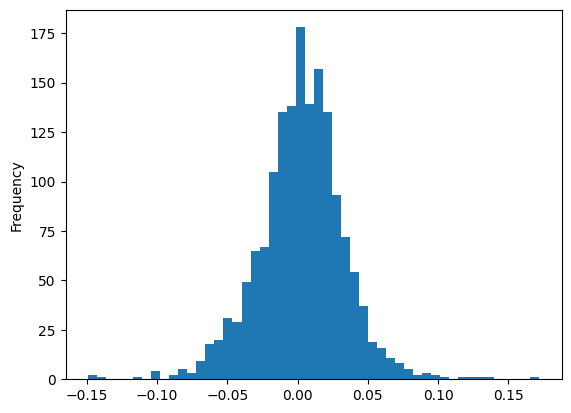

In [322]:
nifty['ret'].plot(kind = 'hist', bins = 50)

In [328]:
import scipy.stats as stats

stats.kurtosis(nifty['ret'].values, fisher=False), stats.skew(nifty['ret'].values)

(np.float64(5.311021335063518), np.float64(-0.12074637036781422))

<Axes: xlabel='ret_outcome', ylabel='Count'>

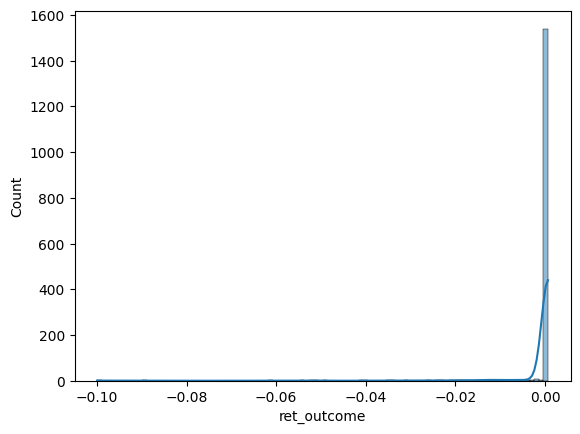

In [343]:
import seaborn as sns
sns.histplot(nifty['ret_outcome'], bins=100, kde=True)


In [481]:
nifty = pd.read_csv("NIFTY 50_Historical_PR_01041994to30042025.csv")
vix = pd.read_csv("India VIX Historical Data.csv")

nifty.set_index(pd.to_datetime(nifty['Date']), drop = True, inplace = True)
nifty = nifty['Close']
nifty.sort_index(inplace=True)

vix.set_index(pd.to_datetime(vix['Date']), drop = True, inplace = True)
vix  = vix['Price']
vix.sort_index(inplace=True)
vix = vix.to_frame()

data = pd.concat([nifty, vix], axis = 1).dropna()
data.columns = ['nifty_price','vix_price']

data['org_date'] = data.index
data['day_name'] = data.index.day_name()

a=data.resample('W-THU').last()
a.index = a['org_date']
a = a['org_date'].to_frame()
a.columns = ['expiry_date']

data = pd.concat([data,a], axis = 1)
#data['expiry_date'].bfill(inplace=True)
data.drop(columns = ['org_date'], inplace=True)
#data = data.loc['2009':]
data

,nifty_price,vix_price,day_name,expiry_date
2008-03-04,4864.25,38.0800,Tuesday,NaT
2008-03-05,4921.40,35.5100,Wednesday,2008-03-05
2008-03-07,4771.60,35.2000,Friday,NaT
2008-03-10,4800.40,32.5800,Monday,NaT
2008-03-11,4865.90,32.6900,Tuesday,NaT
...,...,...,...,...
2025-04-09,22399.15,21.4300,Wednesday,2025-04-09
2025-04-11,22828.55,20.1075,Friday,NaT
2025-04-15,23328.55,16.1250,Tuesday,NaT
2025-04-16,23437.20,15.8650,Wednesday,NaT


In [482]:
from py_vollib.black_scholes import black_scholes

black_scholes('p', 24400, 23000, 7/365, 0.06, 0.25)

np.float64(13.589247241764449)

In [483]:
data['expiry_date'].iloc[2:].dropna()[1]

Timestamp('2008-03-19 00:00:00')

In [484]:
b = data['expiry_date'].iloc[2:].dropna()[1] - data['expiry_date'].iloc[2:].dropna()[0]
b.days/365

0.01643835616438356

In [502]:
trade = False
dist = 0.049
premium = 0.00067

logs = []

for i in range(len(data)-1):
    
    
    if trade == True:
        if pd.isna(data.iloc[i]['expiry_date']) == False:
            profit = min(premium_received, data['nifty_price'].iloc[i]-strike)
            trade = False
            
            logs.append([strike, expiry_date, data.index[i], premium_received, profit, 'expired_otm'])
            
            
    if trade == False:
        if pd.isna(data.iloc[i]['expiry_date']) == False:
            strike = data['nifty_price'].iloc[i]*(1-dist)
            expiry_date = data['expiry_date'].iloc[i+1:].dropna()[0]
            days_to_expiry = expiry_date - data.index[i]
            
            premium_received = max(black_scholes('p', 
                                    data['nifty_price'].iloc[i], 
                                    strike, 
                                    days_to_expiry.days/365, 
                                    0.06, 
                                    data['vix_price'].iloc[i]/100),
                                    data['nifty_price'].iloc[i] * premium)
            trade = True
            
            
#     if trade == True:
#         if data['nifty_price'].iloc[i]<=strike:
#             days_to_expiry = expiry_date - data.index[i]
#             selling_prem = black_scholes('p', 
#                                          data['nifty_price'].iloc[i], 
#                                          strike, 
#                                          days_to_expiry.days/365, 
#                                          0.06, 
#                                          data['vix_price'].iloc[i]/100)
            
#             trade = False
#             profit = premium_received-selling_prem
#             logs.append([strike, expiry_date, data.index[i], premium_received, profit, 'expired_itm'])
 
    

In [503]:
data_df = pd.DataFrame(logs, columns = ['strike', 'expiry', 'exited_on', 'premium','profit', 'expired_otm_itm'])
data_df['profits_cum'] = data_df['profit'].cumsum()
data_df.index = data_df['exited_on']
data_df['ret'] = 1+ (data_df['profit']/data_df['strike']*(0.951))*10
data_df['cum_ret'] = data_df['ret'].cumprod()
data_df.sort_values(by = 'ret').head(20)


,strike,expiry,exited_on,premium,profit,expired_otm_itm,profits_cum,ret,cum_ret
exited_on,,,,,,,,,
2020-03-12,10716.81900,2020-03-12,2020-03-12,8.289291,-1126.66900,expired_otm,1719.014419,0.000205,0.002234
2020-03-19,9120.23265,2020-03-19,2020-03-19,53.345198,-856.78265,expired_otm,862.231769,0.106601,0.000238
2008-10-08,3757.16325,2008-10-08,2008-10-08,14.502340,-243.51325,expired_otm,-177.783058,0.383628,0.378613
2008-11-20,2708.87595,2008-11-20,2008-11-20,57.984101,-155.72595,expired_otm,-586.425879,0.453296,0.058720
2008-10-23,3109.10430,2008-10-23,2008-10-23,26.432587,-165.95430,expired_otm,-415.918508,0.492386,0.148126
2008-07-03,4104.37335,2008-07-03,2008-07-03,12.376285,-178.62335,expired_otm,-58.760489,0.586122,0.745741
2008-10-29,2798.93565,2008-10-29,2008-10-29,27.586707,-101.88565,expired_otm,-517.804158,0.653821,0.096848
2009-06-18,4410.45270,2009-06-18,2009-06-18,25.560617,-159.05270,expired_otm,-226.888401,0.657044,0.167605
2009-03-05,2649.15315,2009-03-05,2009-03-05,14.221277,-72.45315,expired_otm,-419.788728,0.739906,0.097736


<Axes: xlabel='exited_on'>

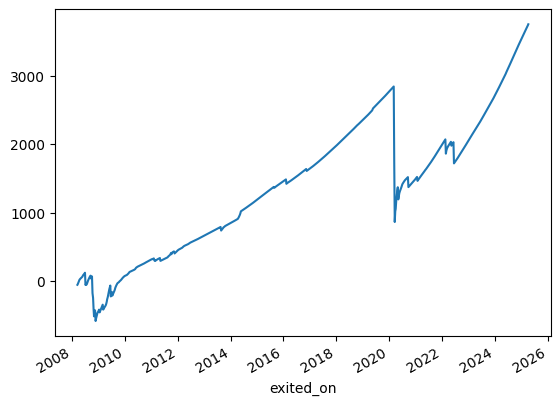

In [504]:
data_df['profits_cum'].plot()
#plt.yscale('log')

<Axes: xlabel='exited_on'>

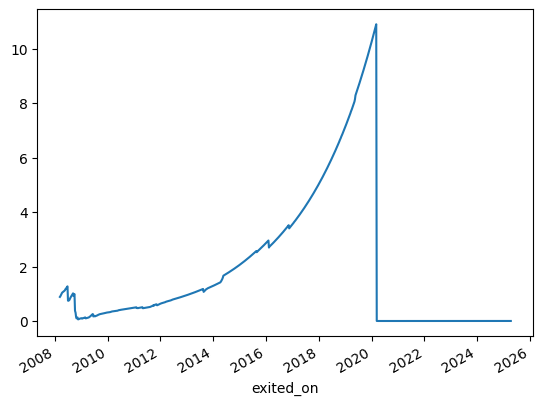

In [505]:
data_df['cum_ret'].plot()
#plt.yscale('log')

<Axes: xlabel='exited_on'>

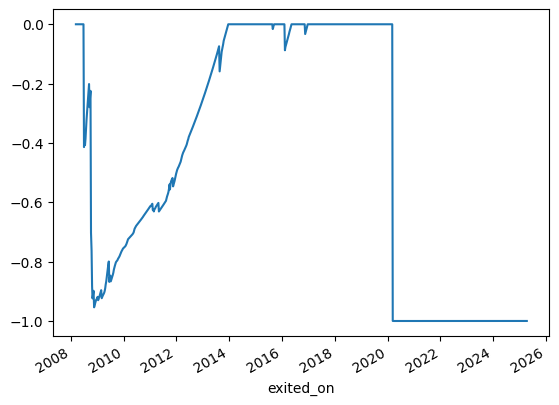

In [506]:
data_df['max_dd'] = (data_df['cum_ret'] - data_df['cum_ret'].cummax())/data_df['cum_ret'].cummax()
data_df['max_dd'].plot()